# Setup

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

import pandas as pd
import numpy as np
from datetime import datetime
import math

np.random.seed(42)

## Functions

In [2]:
# Set random seed for reproducibility


def generate_category_data(category_name, params, start_date, end_date):
    """
    Generate time series data for a single car rental category.
    
    Parameters:
    category_name (str): Name of the car category
    params (dict): Dictionary containing category parameters
    start_date (datetime): Start date for data generation
    end_date (datetime): End date for data generation
    
    Returns:
    pd.DataFrame: DataFrame with columns ['date', 'category', 'n_rented']
    """
    
    # Create date range
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Initialize storage for demand values
    demand_values = []
    previous_value = None
    
    for date in dates:
        day_of_year = date.timetuple().tm_yday
        day_of_week = date.weekday()  # 0=Monday, 6=Sunday
        days_since_start = (date - start_date).days
        
        # Base demand with trend
        base = params['base_demand'] * (1 + params['trend'] * days_since_start)
        
        # Annual seasonality (peak in summer for most categories)
        annual_factor = 1 + params['annual_seasonality'] * math.sin(2 * math.pi * day_of_year / 365.25 - math.pi/2)
        
        # Special winter peak for SUVs
        if category_name == 'SUV':
            winter_factor = 1 + 0.2 * math.sin(2 * math.pi * day_of_year / 365.25 + math.pi/2)
            annual_factor = (annual_factor + winter_factor) / 2
        
        # Weekly seasonality (higher on weekends)
        if day_of_week >= 5:  # Saturday or Sunday
            weekly_factor = 1 + params['weekly_seasonality']
        else:
            weekly_factor = 1 - params['weekly_seasonality'] * 0.3

        holiday_factor = 1.0
        if params['holidays'] == True:
            # Holiday effects (simplified)
            if date.month == 12 and date.day >= 20:  # Christmas/New Year
                holiday_factor = 1.3
            elif date.month == 7 and date.day >= 1 and date.day <= 7:  # 4th of July week
                holiday_factor = 1.2
            elif date.month == 11 and date.day >= 22 and date.day <= 28:  # Thanksgiving week
                holiday_factor = 1.15
        
        # Random demand shocks (economic events, local events, etc.)
        shock_factor = 1.0
        if np.random.random() < params['shock_probability']:
            shock_direction = np.random.choice([-1, 1])
            shock_magnitude = np.random.uniform(0.5, 1.0) * params['shock_magnitude']
            shock_factor = 1 + (shock_direction * shock_magnitude)
        
        # Calculate expected demand
        expected_demand = base * annual_factor * weekly_factor * holiday_factor * shock_factor
        
        # Add multiple sources of randomness
        # 1. Base random noise
        base_noise = np.random.normal(0, params['noise_level'] * expected_demand)
        
        # 2. Autocorrelated component (depends on previous day's deviation)
        autocorr_noise = 0
        if previous_value is not None:
            prev_expected = previous_value['expected']
            prev_actual = previous_value['actual']
            prev_deviation = prev_actual - prev_expected
            autocorr_noise = params['autocorr_factor'] * prev_deviation
        
        # 3. Additional random walk component
        walk_noise = np.random.normal(0, params['noise_level'] * expected_demand * 0.3)
        
        # 4. Occasional outliers (different from shocks)
        outlier_noise = 0
        if np.random.random() < 0.005:  # 0.5% chance of outlier
            outlier_direction = np.random.choice([-1, 1])
            outlier_magnitude = np.random.uniform(1.5, 3.0) * params['noise_level'] * expected_demand
            outlier_noise = outlier_direction * outlier_magnitude
        
        # Combine all noise sources
        total_noise = base_noise + autocorr_noise + walk_noise + outlier_noise
        
        # Calculate final demand
        final_demand = max(0, expected_demand + total_noise)
        
        # Store for autocorrelation
        previous_value = {
            'expected': expected_demand,
            'actual': final_demand
        }
        
        demand_values.append(final_demand)
    
    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'category': category_name,
        'n_rented': demand_values
    })
    
    # Apply smoothing to reduce day-to-day volatility while preserving patterns
    # Apply a 3-day rolling average with some randomness
    rolling_avg = df['n_rented'].rolling(window=params['rolling_avg_days'], center=True, min_periods=1).mean()
    
    # Blend original data with smoothed version (70% smoothed, 30% original)
    smoothing_factor = params['smoothing_factor']
    df['n_rented_smooth'] = (smoothing_factor * rolling_avg + 
                             (1 - smoothing_factor) * df['n_rented'])
    
    # Add some controlled randomness back
    # random_adjustment = np.random.normal(0, 0.1, len(df))
    df['n_rented_final'] = df['n_rented_smooth']# * (1 + random_adjustment)
    
    # Ensure non-negative integers
    df['n_rented'] = np.maximum(0, df['n_rented_final']).astype(int)
    
    # Keep only required columns
    df = df[['date', 'category', 'n_rented']].copy()
    
    # Convert date to string format
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    
    return df


def generate_rental_car_dataset(car_categories, start_date, end_date):
    """
    Generate complete rental car dataset for multiple categories.
    
    Parameters:
    car_categories (dict): Dictionary with category names as keys and parameter dicts as values
    start_date (datetime): Start date for data generation
    end_date (datetime): End date for data generation
    
    Returns:
    pd.DataFrame: Complete dataset with all categories
    """
    
    category_dataframes = []
    
    print("Generating data for categories:")
    for category_name, params in car_categories.items():
        print(f"  - {category_name}")
        category_df = generate_category_data(category_name, params, start_date, end_date)
        category_dataframes.append(category_df)
    
    # Combine all category dataframes
    complete_df = pd.concat(category_dataframes, ignore_index=True)
    
    # Sort by date and category
    complete_df = complete_df.sort_values(['date', 'category']).reset_index(drop=True)
    
    return complete_df

In [3]:

def plot_category_demand(df, category_name):
    """
    Plot daily demand for a specific car category from rental car CSV data.
    
    Parameters:
    csv_file_path (str): Path to the CSV file containing rental car data
    category_name (str): Name of the car category to plot
    
    Returns:
    None (displays the plot)
    """
    
    # Check if required columns exist
    required_columns = ['date', 'category', 'n_rented']
    if not all(col in df.columns for col in required_columns):
        print(f"Error: CSV must contain columns: {required_columns}")
        print(f"Found columns: {df.columns.tolist()}")
        return
    
    # Check if category exists
    available_categories = df['category'].unique()
    if category_name not in available_categories:
        print(f"Error: Category '{category_name}' not found in data.")
        print(f"Available categories: {available_categories.tolist()}")
        return
    
    # Filter data for the specified category
    category_data = df[df['category'] == category_name].copy()
    
    # Convert date column to datetime
    category_data['date'] = pd.to_datetime(category_data['date'])
    
    # Sort by date
    category_data = category_data.sort_values('date')
    
    # Create the plot
    plt.figure(figsize=(8, 4))
    plt.plot(category_data['date'], category_data['n_rented'], 
             linewidth=1, color='steelblue', alpha=0.8)
    
    # Customize the plot
    plt.title(f'Daily Rental Demand: {category_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Cars Rented', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Format x-axis to show dates nicely
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Add some statistics to the plot
    mean_demand = category_data['n_rented'].mean()
    max_demand = category_data['n_rented'].max()
    min_demand = category_data['n_rented'].min()
    
    plt.axhline(y=mean_demand, color='red', linestyle='--', alpha=0.7, 
                label=f'Mean: {mean_demand:.1f}')
    
    # Add legend and stats box
    stats_text = f'Mean: {mean_demand:.1f}\nMax: {max_demand}\nMin: {min_demand}\nTotal Days: {len(category_data)}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # # Print summary statistics
    # print(f"\nSummary for {category_name}:")
    # print(f"Date range: {category_data['date'].min().strftime('%Y-%m-%d')} to {category_data['date'].max().strftime('%Y-%m-%d')}")
    # print(f"Total observations: {len(category_data)}")
    # print(f"Mean daily demand: {mean_demand:.2f}")
    # print(f"Standard deviation: {category_data['n_rented'].std():.2f}")
    # print(f"Min demand: {min_demand}")
    # print(f"Max demand: {max_demand}")

# Generate Data

In [4]:
car_categories = {
    'Car A': {
        'base_demand': 70,
        'trend': 0.0008,  
        'annual_seasonality': 0.15,  
        'weekly_seasonality': 0.01,  
        'noise_level': 0.15,
        'shock_probability': 0.02,  
        'shock_magnitude': 0.02,  
        'autocorr_factor': 0.01,  
        'rolling_avg_days': 30,
        'smoothing_factor': .9,
        'holidays': True
    },
    'Car B': {
        'base_demand': 100,
        'trend': -0.00008,  
        'annual_seasonality': 0.1,  
        'weekly_seasonality': 0.001,  
        'noise_level': 0.75,
        'shock_probability': 0.002,  
        'shock_magnitude': 0.002,  
        'autocorr_factor': 0.01,  
        'rolling_avg_days': 180,
        'smoothing_factor': .99,
        'holidays': True
    },
    'Car C': {
        'base_demand': 30,
        'trend': 0,  
        'annual_seasonality': 0.1,  
        'weekly_seasonality': 0.001,  
        'noise_level': 0.4,
        'shock_probability': 0.02,  
        'shock_magnitude': 0.02,  
        'autocorr_factor': 0.01,  
        'rolling_avg_days': 180,
        'smoothing_factor': .99,
        'holidays': True
    },
    'Car D':{
        'base_demand': 1200,
        'trend': 0,  
        'annual_seasonality': 0.2,  
        'weekly_seasonality': 0.01,  
        'noise_level': 0,
        'shock_probability': 0,  
        'shock_magnitude': 0,  
        'autocorr_factor': 0,  
        'rolling_avg_days': 180,
        'smoothing_factor': 0,
        'holidays': False
    },
    'Car E': {
        'base_demand': 15,
        'trend': 0,  
        'annual_seasonality': 0.1,  
        'weekly_seasonality': 0.001,  
        'noise_level': 0.4,
        'shock_probability': 0.02,  
        'shock_magnitude': 0.02,  
        'autocorr_factor': 0.01,  
        'rolling_avg_days': 180,
        'smoothing_factor': .99,
        'holidays': True
    },
}

Starting rental car dataset generation...
Generating data for categories:
  - Car A
  - Car B
  - Car C
  - Car D
  - Car E


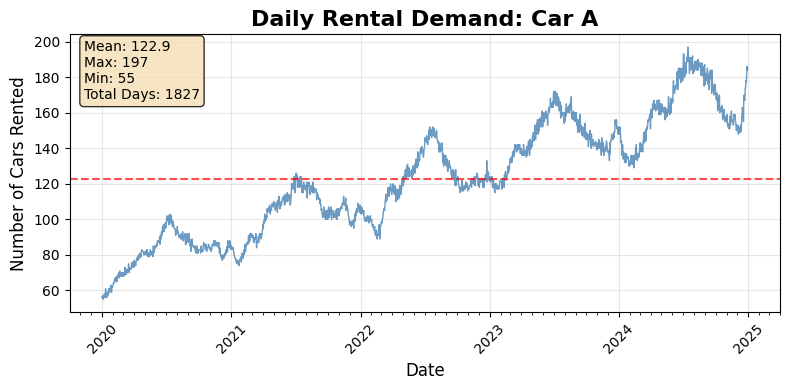

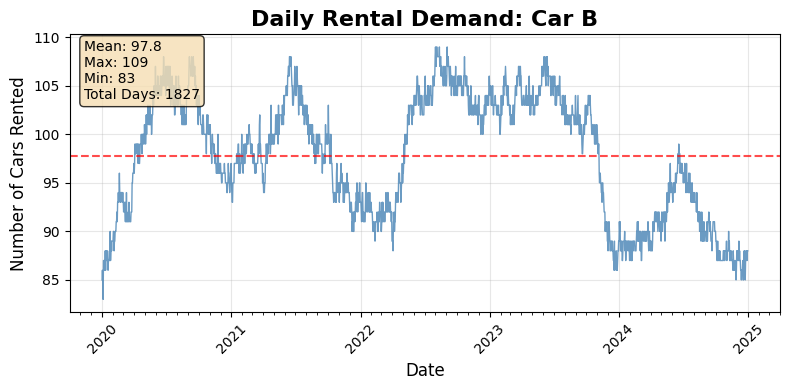

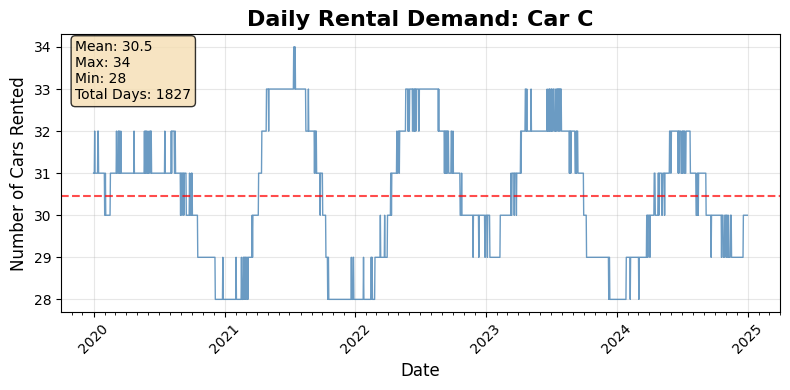

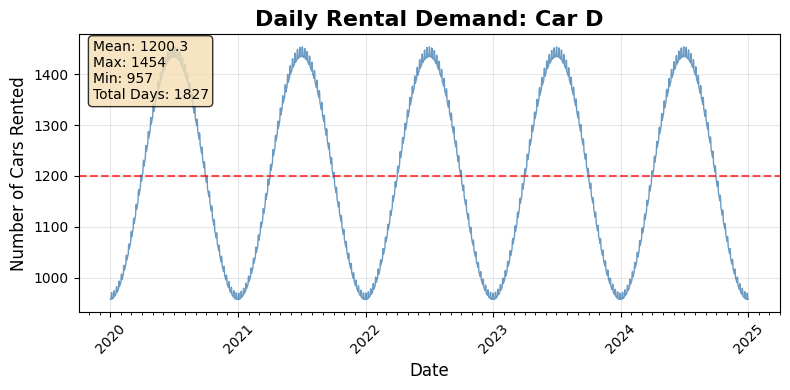

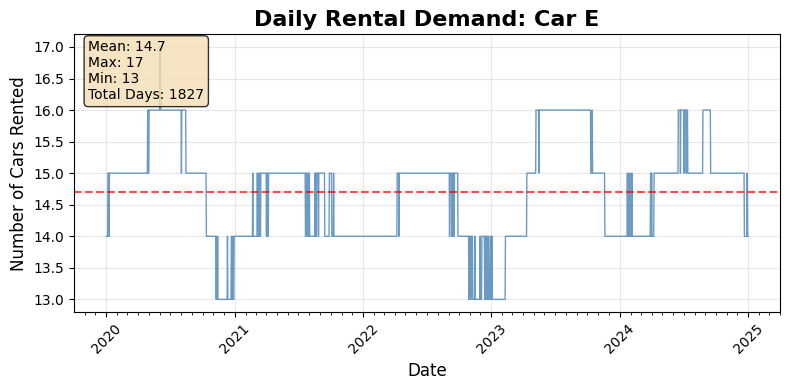

In [5]:
start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 12, 31)

# Generate complete dataset
print("Starting rental car dataset generation...")
df = generate_rental_car_dataset(car_categories, start_date, end_date)

categories = df["category"].unique()

for cat in categories:
    plot_category_demand(df, cat)

# Write

In [6]:
df.to_csv('rental_car_time_series.csv', index=False)